In [2]:
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

sber_data = pd.read_csv('data/sber_data.csv')

sber_data['life_sq'].describe()

count    24088.000000
mean        34.403271
std         52.285733
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

Логичен вопрос: а много ли у нас таких квартир, у которых жилая площадь больше, чем суммарная?

Давайте проверим это с помощью фильтрации:

In [3]:
outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']]
outliers.shape[0]
#удоляем все квартиры с анамальной площадью
cleaned = sber_data.drop(outliers.index,axis=0)
cleaned.shape[0]

30434

In [4]:
sber_data['floor'].describe()

count    30304.000000
mean         7.670803
std          5.319989
min          0.000000
25%          3.000000
50%          6.500000
75%         11.000000
max         77.000000
Name: floor, dtype: float64

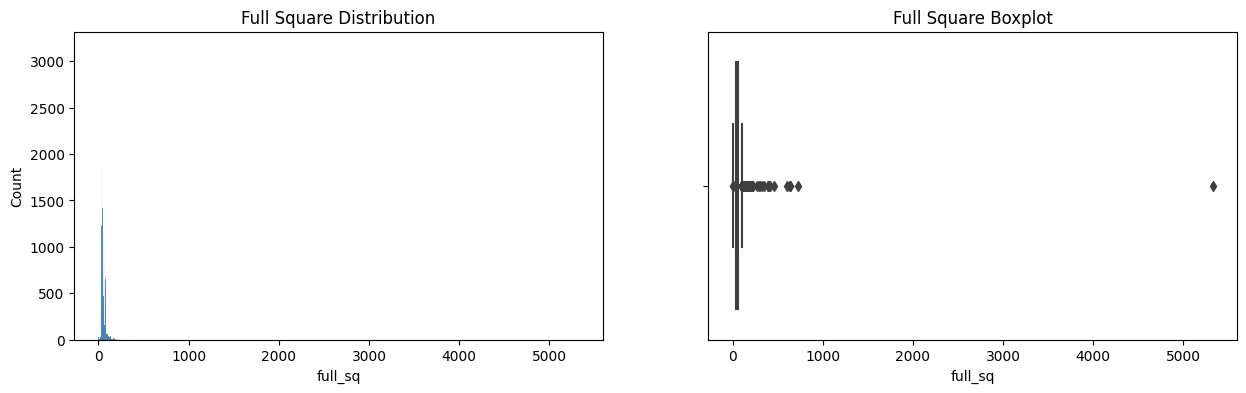

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

In [6]:
def outlires_iqr(data,feature):
    x =data[feature]
    quartel_1,quartel_3 = x.quantile(0.25),x.quantile(0.75)
    iqr = quartel_3 - quartel_1
    lower_bound = quartel_1 - (iqr * 1.5)
    upper_bound = quartel_3 + (iqr * 1.5)
    outlires = data[(x < lower_bound)|(x > upper_bound)]
    cleaned = data[(x >= lower_bound)&(x <= upper_bound)]
    return outlires,cleaned


outlires,cleaned = outlires_iqr(sber_data,'full_sq')

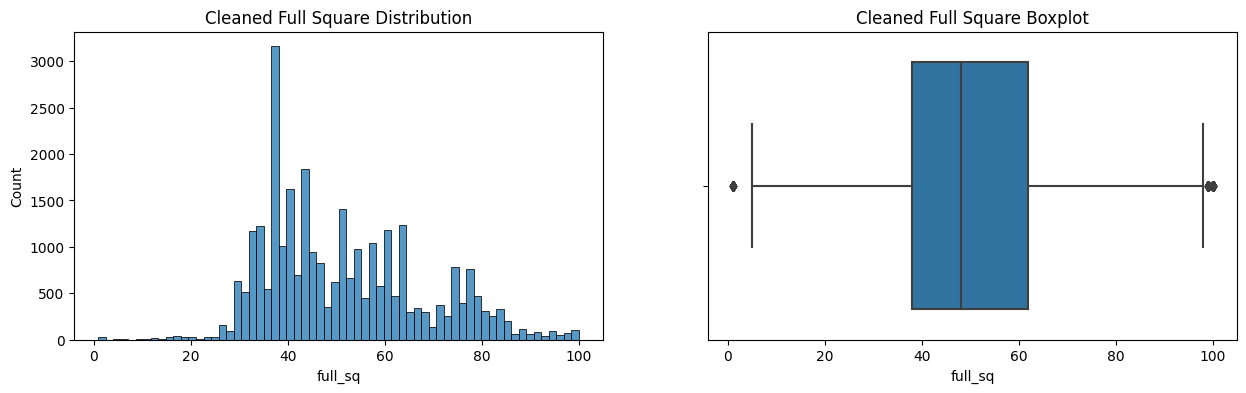

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

Давайте расширим правило трёх сигм, чтобы иметь возможность особенности данных. Добавьте в функцию outliers_z_score(data, feature, log_scale=False) параметры left и right, которые будут задавать число сигм (стандартных отклонений) влево и вправо соответственно, определяющее границы метода z-отклонения. По умолчанию оба параметры равны 3.

Результирующую функцию назовите outliers_z_score_mod().

Можете протестировать работу функции на DataFrame test_sber_data.csv. Проверять ваше решение мы будем, подавая на вход функции вместо data произвольный датафрейм.

Добавьте фишку с логарифмированием в свою функцию outliers_iqr_mod(). Добавьте в неё параметр log_scale. Если он выставлен в True, то производится логарифмирование признака. Примените полученную функцию к признаку price_doc. Число межквартильных размахов в обе стороны обозначьте как 3. Чему равно число выбросов, полученных таким методом?

In [8]:
def outliers_iqr_mod(data, feature,left=1.5,right=1.5,log_scale=True):
    if log_scale:
        x = np.log(data[feature] )
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', log_scale=True,left=3,right=3)
outliers.shape[0]

92

МЕТОД Z-ОТКЛОНЕНИЙ (МЕТОД СИГМ)

Последний метод, который мы рассмотрим, — это метод, основанный на правиле трёх сигм для нормального распределения. 

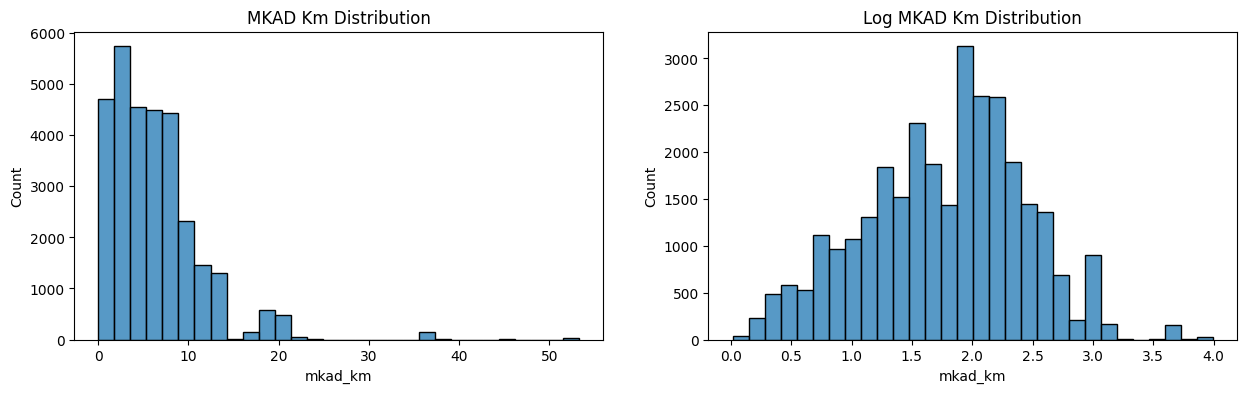

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

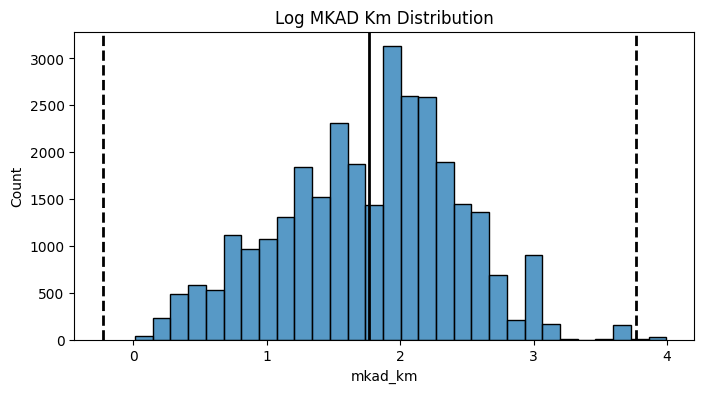

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

 Примечание: Численный показатель асимметрии можно вычислить с помощью метода:

skew():

print(log_mkad_km.skew())

 -0.14263612203024953

Асимметрия распределения называется правосторонней, если она положительная:
;

Асимметрия распределения называется левосторонней, если она отрицательная:

In [11]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outlires = data[(x < lower_bound)|(x > upper_bound)]
    cleaned = data[(x >= lower_bound)&(x <= upper_bound)]
    return outlires,cleaned

outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438


In [12]:
print(outliers['sub_area'].unique())

['Poselenie Rogovskoe' 'Poselenie Kievskij']


In [13]:
def outliers_z_score_mod(data, feature, log_scale=False,left=3,right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score_mod(sber_data,'mkad_km', left=3, right=3.5, log_scale=True)
outliers.shape[0]

0

Постройте гистограмму для признака price_doc в логарифмическом масштабе. А также, добавьте на график линии, отображающие среднее и границы интервала для метода трех сигм. Выберите верные утверждения:

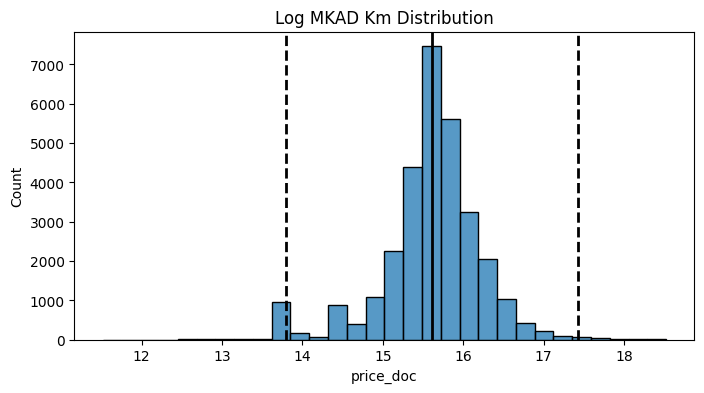

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

In [15]:
sber_data['price_doc'].skew()

4.474744873569561

Найдите потенциальные выбросы с помощью метода z-отклонения. Используйте логарифмический масштаб распределения. Сделайте «послабление» на 0.7 сигм в в обе стороны распределения. Сколько выбросов вы получили?

In [16]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3.7 * sigma
    upper_bound = mu + 3.7 * sigma
    outlires = data[(x < lower_bound)|(x > upper_bound)]
    cleaned = data[(x >= lower_bound)&(x <= upper_bound)]
    return outlires,cleaned

outliers, cleaned = outliers_z_score(sber_data, 'price_doc', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 52
Результирующее число записей: 30419


#### ДУБЛИКАТЫ

Иногда данные могут содержать повторяющиеся записи (дубликаты).

Дубликатами называются записи, для которых значения (всех или большинства) признаков совпадают. 

✍️ Найдём число полных дубликатов таблице sber_data. Предварительно создадим список столбцов dupl_columns, по которым будем искать совпадения (все столбцы, не включая id). 

Создадим маску дубликатов с помощью метода duplicated() и произведём фильтрацию. Результат заносим в переменную sber_duplicates. Выведем число строк в результирующем DataFrame:

In [17]:
dupl_columns = list(sber_data.columns)
dupl_columns.remove('id')

mask = sber_data.duplicated(subset=dupl_columns)
sber_duplicates = sber_data[mask]
display(sber_duplicates.shape[0])

562

✍️ Создадим новую таблицу sber_dedupped, которая будет версией исходной таблицы, очищенной от полных дубликатов.

In [18]:
sber_dedupped = sber_data.drop_duplicates(subset=dupl_columns)
sber_dedupped.shape[0]

29909

#### НЕИНФОРМАТИВНЫЕ ПРИЗНАКИ

Отсутствием новой и полезной информации могут «похвастаться» не только отдельные записи в таблице, но и целые признаки.

Неинформативными называются признаки, в которых большая часть строк содержит одинаковые значения (например, пол клиентов в мужском барбершопе), либо наоборот — признак, в котором для большинства записей значения уникальны (например, номер телефона клиента). 

Разберём алгоритм:

→ Создаём пустой список low_information_cols, куда будем добавлять названия признаков, которые мы посчитаем неинформативными.

→ В цикле пройдёмся по всем именам столбцов в таблице и для каждого будем совершать следующие действия:

рассчитаем top_freq — наибольшую относительную частоту с помощью метода value_counts() с параметром normalize=True. Метод вернёт долю от общих данных, которую занимает каждое уникальное значение в признаке.
Например, для столбца oil_chemistry_raion (нефтехимический район) результат будет следующим:

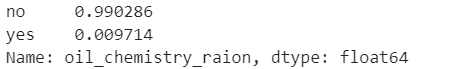


Отсюда нам нужен максимум.

рассчитаем nunique_ratio — отношение числа уникальных значений в столбце к размеру всего столбца. Число уникальных значений в столбце получим с помощью метода nunique(), а размер признака — с помощью метода count(). Например, для столбца id число уникальных значений — 30471; оно же равно размеру таблицы. Поэтому результат отношения будет 1.
сравним каждое из полученных чисел с пороговым значением (у нас это 0.95) и добавим в список неинформативных признаков, если условие истинно.

In [19]:
low_information_cols = list()
for col in sber_data.columns:
    top_freq = sber_data[col].value_counts(normalize=True).max()
    nunique_ratio = sber_data[col].nunique() / sber_data[col].count()
    if top_freq > 0.95:
        low_information_cols.append(col)
        print('{}: {}% одинаковых значений'.format(col,round(top_freq * 100,2)))
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print('{}: {}% уникальных значений'.format(col,round(nunique_ratio * 100,2)))

    

id: 100.0% уникальных значений
oil_chemistry_raion: 99.03% одинаковых значений
railroad_terminal_raion: 96.27% одинаковых значений
nuclear_reactor_raion: 97.17% одинаковых значений
big_road1_1line: 97.44% одинаковых значений
mosque_count_1000: 98.08% одинаковых значений


In [20]:
information_sber_data = sber_data.drop(low_information_cols,axis=1)
information_sber_data.shape

(30471, 55)